<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/rebalanceamento_01/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aplicação de Modelos de Confiabilidade e Metaheurísticas na Otimização de Carteiras de Investimentos com Rebalanceamentos relacionados ao risco**


**Objetivo**

O objetivo do trabalho é desenvolver e validar uma metodologia para a otimização de carteiras de investimento, com foco na identificação da necessidade e nos valores ótimos dos rebalanceamentos dos ativos. A proposta envolve a modelagem da ocorrência de eventos de mercado que possam impactar significativamente os preços dos ativos, bem como notas de agência de avaliação. O estudo será realizado utilizando Modelos de Sobrevivência baseados na Distribuição de Weibull com Frailty, a fim de capturar riscos externos não observáveis, como notícias inesperadas e decisões governamentais. Os dados serão extraídos em 3 arquivos csv diferentes, o primeiro direto de uma base da B3, que será o relatório consolidado da carteira de investimentos. O segundo será extraído da api da Brapi com os dados dos ativos. E o terceiro de alguma agência de avaliação (ainda em avaliação).
Os parâmetros dos modelos serão estimados utilizando a função de Máxima Verossimilhança, garantindo o ajuste adequado aos dados históricos das séries de preços dos ativos. A partir da modelagem dos eventos, pretende-se determinar, por meio de Otimização Bayesiana, os pontos ótimos de rebalanceamento dos ativos da carteira, considerando informações como preço atual, preço médio, número de ações, valor total investido em cada ativo e valor total investido na carteira. Os dados serão extraídos em um 3 arquivo csv direto de uma base da B3.
Além disso, será realizada a otimização multiobjetiva da carteira empregando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization), visando simultaneamente:
•	Maximizar o retorno esperado,
•	Minimizar o risco da carteira,
•	Minimizar os custos associados aos rebalanceamentos.
Por fim, será conduzida uma análise comparativa entre as abordagens propostas, com a avaliação de métricas de qualidade de soluções multiobjetivas (como hipervolume, spread e IGD) e comparação com estratégias tradicionais de rebalanceamento periódico, buscando evidenciar as vantagens e limitações da metodologia em cenários práticos.

**Objetivo Específico**

1.	Modelar a ocorrência de eventos de mercado que possam afetar significativamente os preços dos ativos, utilizando Modelos de Sobrevivência baseados na Distribuição de Weibull com Frailty para capturar riscos não observáveis.

2.	Utilizar Otimização Bayesiana por meio da biblioteca Optuna para determinar os pesos ótimos dos ativos na carteira, considerando o retorno esperado, risco e custos de rebalanceamento.

3.	Implementar a otimização multiobjetiva da carteira utilizando os algoritmos NSGA-II (Non-dominated Sorting Genetic Algorithm II) e MOPSO (Multi-Objective Particle Swarm Optimization) para maximizar o retorno esperado, minimizar o risco da carteira e os custos associados aos rebalanceamentos.


4.	Realizar uma análise comparativa entre as abordagens propostas (Otimização Bayesiana com Optuna, NSGA-II e MOPSO), avaliando as soluções geradas através de métricas de qualidade multiobjetiva, como hipervolume, spread e IGD, e comparando com estratégias tradicionais de rebalanceamento periódico.


In [1]:
# **Instalação de Bibliotecas e Importação de Dependências**
%%capture
!pip install lifelines -U pymoo seaborn optuna pytesseract opencv-python

In [70]:
# Bibliotecas essenciais para manipulação de dados e otimização
import numpy as np
import pandas as pd
import optuna
import requests
import seaborn as sns
import cv2
import pytesseract
import re
import lifelines
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Bibliotecas de análise de sobrevivência
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter

# Bibliotecas de otimização multiobjetivo
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.indicators.hv import HV
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Suporte para exibir imagens no Colab
from google.colab.patches import cv2_imshow

# Ferramentas adicionais
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Token para acesso à API da Brapi (https://brapi.dev/)
token = 'wQsv3whghhynsSiXQj18Jm'

# Intervalo de tempo para consulta dos dados históricos
interval = '3mo'

# Valor de aporte para simulações e otimização
VALOR_APORTE = 5000.00  # Exemplo: R$ 5.000,00 de aporte inicial

Nesse ponto foi criado um arquivo com dados simulados. Porem, esses dados podem ser extraido da B3.

Para realizar a simulação foi utilizado o codigo: https://github.com/uervitonsantos/simula-dados-carteira-investimentos/blob/main/Simula_dados_de_opera%C3%A7%C3%B5es_em_cateira_de_investimento.ipynb

Link para acesso ao Dataset: https://drive.google.com/file/d/1-15NzorUCz7iS8TuuATr6ADaOYdbOlOF/view?usp=drive_link

In [5]:
# Leitura dos dados da carteira inicial contendo os ativos a serem analisados
df = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/carteira-de-ativos.csv', sep=",")

# Visualização dos primeiros registros do dataset
df.head(3)

,Entrada/Saída,Data,Produto,Quantidade,Preço unitário,Valor da Operação
0,Compra,15/03/2021,VALE3 - VALE S.A.,8,"R$ 73,02","R$ 584,16"
1,Compra,14/04/2021,VALE3 - VALE S.A.,62,"R$ 54,78","R$ 3.396,36"
2,Compra,14/05/2021,VALE3 - VALE S.A.,4,"R$ 69,01","R$ 276,04"


# **Pré-processamento e Organização dos Dados Operacionais**

Nesta etapa, foi realizado o pré-processamento dos dados provenientes de operações financeiras, com o objetivo de estruturá-los adequadamente para análise. Inicialmente, a coluna correspondente às datas das operações foi convertida para o tipo datetime, utilizando o parâmetro dayfirst=True para considerar o formato de data com o dia precedendo o mês, padrão comum no Brasil. Em seguida, realizou-se a padronização da coluna referente aos produtos negociados, por meio da aplicação de uma expressão regular que extrai exclusivamente o código do ativo (ticker), tipicamente formado por quatro letras seguidas de um número, como PETR4 ou VALE3.

A partir desses códigos, foi criada uma nova coluna chamada "Ticker", que isola o identificador do ativo, removendo possíveis descrições adicionais que pudessem estar presentes. Para caracterizar o tipo de operação, a coluna "Entrada/Saída" foi mapeada para valores numéricos, atribuindo 1 às operações de compra (indicando entrada do ativo na carteira) e 0 às de venda (representando a saída do ativo).

Com o intuito de calcular o tempo decorrido desde cada operação até a data de referência da análise, foi criada a variável "Tempo", obtida pela diferença entre a data atual do sistema e a data da operação. Para evitar valores nulos ou negativos, somou-se uma unidade ao resultado e aplicou-se um limite inferior mínimo de 0.1, garantindo valores positivos em formato de ponto flutuante.

Adicionalmente, os valores monetários presentes nas colunas "Valor da Operação" e "Preço unitário" foram tratados para remover formatações específicas do sistema financeiro brasileiro, como o símbolo de real (R$), os separadores de milhar (.) e a vírgula decimal (,) que foram convertidos para o padrão numérico utilizado no ambiente de programação. Após essas transformações, os campos foram convertidos para o tipo float.

Por fim, com vistas à obtenção de uma série histórica representativa, os dados foram agrupados por data e ticker, e o preço médio unitário foi calculado para cada ativo em cada data, utilizando a função de média (mean). Esse agrupamento foi reestruturado com a função unstack, resultando em uma tabela bidimensional onde as colunas representam os diferentes ativos e as linhas representam as datas, com os respectivos preços médios históricos.

In [6]:
# Garante que a coluna 'Data' está no formato datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True, errors='coerce')

# Extração do ticker dos ativos a partir da coluna 'Produto'
# Exemplo de 'Produto': 'CSAN3 - COSAN'
df['Ticker'] = df['Produto'].str.extract(r'([A-Z]{4,5}\d{1,2})')

# Cria uma coluna 'Ticker' apenas com o código do ativo antes de qualquer descrição
df['Ticker'] = df['Produto'].str.split(' - ').str[0].str.strip()

# Mapeamento do tipo de operação para evento binário:
# Compra = 1 (ativo entra na carteira)
# Venda = 0 (ativo sai da carteira)
df['Evento'] = df['Entrada/Saída'].map({'Compra': 1, 'Venda': 0})

# Cálculo do tempo (em dias) desde a data da operação até a data atual
data_referencia = pd.to_datetime(datetime.today().date())  # Data atual
df['Tempo'] = (data_referencia - df['Data']).dt.days + 1  # Adiciona +1 para evitar zero
df['Tempo'] = df['Tempo'].clip(lower=0.1).astype(float)   # Garante que seja positivo e float

# Limpeza dos valores monetários nas colunas de operação e preço unitário
# Remove 'R$', pontos e substitui vírgula por ponto
df['Valor da Operação'] = (df['Valor da Operação'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float))
df['Preço unitário'] = (df['Preço unitário'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float))

# Agrupa por data e ticker, calculando o preço médio do ativo na data
precos_historicos = (df.groupby(['Data', 'Ticker'])['Preço unitário'].mean().unstack())  # Cria uma tabela onde cada coluna é um ticker

# **Cálculo do Tempo Mediano de Permanência dos Ativos na Carteira**

Com o objetivo de analisar a dinâmica de permanência dos ativos na carteira ao longo do tempo, foi desenvolvido um procedimento para estimar, por ativo (ticker), o tempo mediano entre a data de compra e a data correspondente de venda. Inicialmente, os dados foram agrupados pela variável "Ticker", de modo que cada grupo representasse o histórico completo de operações de um determinado ativo.

Para cada ativo, foram separadas as listas de datas de compra (operações marcadas com valor 1 na coluna "Evento") e de venda (operações com valor 0). As listas foram ordenadas cronologicamente para garantir que os emparelhamentos fossem realizados na ordem temporal correta. Em seguida, utilizou-se a função zip para emparelhar cada data de compra com a correspondente data de venda subsequente, assumindo que as operações seguem uma lógica FIFO (First-In, First-Out). Apenas pares com venda posterior à compra foram considerados válidos para o cálculo.

Para cada par válido (compra, venda), foi calculado o número de dias decorridos entre as duas datas. A partir da lista de intervalos obtida para cada ativo, foi então calculada a mediana do tempo de permanência, de forma a obter uma medida robusta em relação a valores extremos ou outliers. Essa informação foi armazenada em um dicionário, onde as chaves representam os tickers e os valores correspondem ao tempo mediano de permanência, em dias.

O resultado final constitui uma estrutura de dados que associa, de maneira eficiente, cada ativo ao seu tempo típico de retenção na carteira, podendo ser utilizada posteriormente em análises de perfil de negociação, construção de estratégias ou avaliação de liquidez.

In [7]:
# Calcula o tempo (em dias) desde a primeira compra até hoje, para cada ticker

data_atual = pd.to_datetime(datetime.today().date())

tempos_por_ticker = (
    df[df['Evento'] == 1]  # Apenas eventos de compra
    .groupby('Ticker')['Data']
    .min()  # Primeira compra
    .apply(lambda d: (data_atual - d).days + 1)  # Tempo em dias
    .to_dict()
)

# Resultado: dicionário {ticker: dias_desde_primeira_compra}

In [8]:
# Seleciona as colunas necessárias para análise de sobrevivência
df_surv = df[['Ticker', 'Tempo', 'Evento']]

# Lista de todos os tickers únicos na base de dados
tickers = df['Ticker'].unique()

Para compor uma análise fundamentalista e técnica dos ativos listados em carteira, foi implementado um procedimento automatizado de extração de dados financeiros e de mercado por meio da API pública Brapi.dev: https://brapi.dev/. A etapa em questão tem como finalidade consultar, para cada ticker (ativo), um conjunto de informações relevantes ao investimento, incluindo preço atual, indicadores fundamentais e variações recentes.

Inicialmente, foi criada uma lista vazia denominada dados_ativos, destinada a armazenar os resultados das consultas realizadas. Em seguida, um laço de repetição (for) percorre a lista de tickers previamente definida, e, para cada ativo, é construída uma URL personalizada contendo parâmetros como intervalo de tempo (range), frequência das cotações (interval=1d), e os módulos desejados, como summaryProfile e fundamental.

A URL é então requisitada via método GET utilizando a biblioteca requests. Caso a resposta da API apresente status de sucesso (200), os dados retornados são processados no formato JSON. Dentre as informações extraídas, está o preço atual de mercado (regularMarketPrice) e o histórico diário de preços de fechamento, contido no campo historicalDataPrice. A partir desses preços de fechamento, calcula-se a média do período e, em seguida, a variação percentual entre o preço atual e essa média, servindo como um indicador técnico de desvio.

Além disso, o código acessa dados fundamentais como o setor da empresa, o preço mínimo e máximo nas últimas 52 semanas, o índice Preço/Lucro (P/L), o Dividend Yield (DY), o Return on Equity (ROE), o Preço sobre Valor Patrimonial (P/VP) e o volume médio de negociação dos últimos três meses. Todos esses dados são armazenados como dicionários dentro da lista dados_ativos, permitindo posterior análise, visualização ou persistência em banco de dados.

Caso a requisição para algum ticker falhe, o sistema emite um alerta na saída padrão, indicando o código de erro HTTP correspondente. Esse tratamento garante maior robustez ao processo de coleta automática. Em conjunto, essa etapa fornece uma base sólida para análises quantitativas e qualitativas de cada ativo em carteira.

In [9]:
# Lista para armazenar os dados extraídos de cada ativo
dados_ativos = []

# Loop para consultar cada ticker da carteira
for ticker in tickers:
    try:
        # Monta a URL de requisição para a API brapi.dev
        url = (
            f'https://brapi.dev/api/quote/{ticker}'
            f'?range={interval}&interval=1d&fundamental=true'
            f'&modules=summaryProfile&token={token}'
        )

        # Faz a requisição HTTP
        response = requests.get(url)

        # Verifica se a resposta foi bem-sucedida (status 200)
        if response.status_code == 200:
            data = response.json()
            print(f"{ticker}: OK")  # Log de sucesso na consulta

            # Extrai o primeiro resultado da resposta
            result = data.get('results', [{}])[0]

            # Preço atual do ativo
            preco_atual = result.get('regularMarketPrice')

            # Processa histórico de preços para calcular a média dos últimos dias
            historico = result.get('historicalDataPrice', [])
            precos_fechamento = [
                dia.get('close') for dia in historico if dia.get('close') is not None
            ]

            # Calcula a média dos preços de fechamento e a variação percentual
            if precos_fechamento:
                media_dias = sum(precos_fechamento) / len(precos_fechamento)
                variacao_pct = (
                    (preco_atual - media_dias) / media_dias if preco_atual else None
                )
            else:
                media_dias = None
                variacao_pct = None

            # Armazena os dados coletados em um dicionário
            dados_ativos.append({
                'Ticker': ticker,
                'Empresa': result.get('shortName'),
                'Setor': result.get('summaryProfile', {}).get('sector'),
                'Preço Atual': preco_atual,
                'Média em Dias': media_dias,
                'Variação % Média em Dias': variacao_pct,
                'Min 52 Semanas': result.get('fiftyTwoWeekLow'),
                'Max 52 Semanas': result.get('fiftyTwoWeekHigh')
            })

        else:
            # Log de erro na requisição
            print(f"{ticker}: ERRO - {response.status_code}")

    except Exception as e:
        # Captura qualquer erro na execução da requisição ou processamento
        print(f"{ticker}: ERRO na requisição - {e}")

VALE3: OK
ITUB4: OK
PETR4: OK
WEGE3: OK
ABEV3: OK


In [10]:
# Converter os dados coletados em um DataFrame do Pandas
df_api = pd.DataFrame(dados_ativos)

# Salvar os dados em arquivo CSV no Google Drive
df_api.to_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv', index=False)

print("\n✅ Dados salvos com sucesso em 'ativos_brapi.csv'.")


✅ Dados salvos com sucesso em 'ativos_brapi.csv'.


In [11]:
# Carregar os dados dos ativos salvos anteriormente no CSV
df_api = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv')

# Visualizar as 10 primeiras linhas do DataFrame
df_api.head(10)

,Ticker,Empresa,Setor,Preço Atual,Média em Dias,Variação % Média em Dias,Min 52 Semanas,Max 52 Semanas
0,VALE3,VALE ON NM,Basic Materials,53.00,53.355738,-0.006667,48.770,65.35
1,ITUB4,ITAUUNIBANCOPN EJ N1,Financial Services,36.27,35.420328,0.023988,27.109,38.62
2,PETR4,PETROBRAS PN N2,Energy,31.21,31.659508,-0.014198,28.860,40.76
3,WEGE3,WEG ON ATZ NM,Industrials,42.35,43.990820,-0.037299,40.850,59.83
4,ABEV3,AMBEV S/A ON,Consumer Defensive,13.15,13.917869,-0.055171,10.720,15.03


Este script Python realiza uma análise fundamentalista de ações da B3 utilizando os dados do site Fundamentus. O objetivo é pontuar e ranquear ações com base em critérios quantitativos de qualidade e valuation.


In [12]:
# Carregar os dados fundamentalistas dos ativos
df_fund = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/pontuacao-dados-fundamentalistas.csv', sep=";")

# Visualizar as 10 primeiras linhas do DataFrame
df_fund.head(10)

,Ação,Pontuação
0,PETR4,83.33
1,VALE3,83.33
2,ABEV3,75.00
3,ITUB4,66.67
4,WEGE3,33.33


# **Cálculo do Fator de Frailty com Base na Variação Percentual e Pontuação Fundamentalista**

Com o intuito de incorporar um elemento de heterogeneidade no modelo de sobrevivência aplicado aos ativos financeiros, foi desenvolvido um procedimento para estimar o chamado fator de frailty (fragilidade) a partir da variação percentual entre o preço atual e a média dos preços de fechamento ao longo de um determinado intervalo de tempo. A noção de frailty é frequentemente utilizada em modelos de análise de sobrevivência para representar fatores não observáveis que afetam o risco de um evento ocorrer — neste caso, a venda de um ativo.

Inicialmente, foi criado um dicionário chamado frailty_fatores, responsável por associar cada ativo ao seu respectivo fator de frailty. Para cada item contido na lista dados_ativos (previamente obtida por meio da API Brapi.dev), extraiu-se a variação percentual entre o preço atual e a média dos preços anteriores. Este valor foi então ajustado para formar um fator multiplicativo segundo a fórmula: frailty = 1 + variação, com arredondamento para duas casas decimais. Caso o dado de variação estivesse ausente (None), foi atribuído o valor neutro de 1.0, indicando ausência de fragilidade adicional.

Na sequência, foi construída uma lista contendo apenas os tickers com dados válidos, assegurando que apenas ativos com informações completas fossem considerados nas etapas subsequentes da análise. O fator de frailty foi então incorporado ao DataFrame principal df, por meio do método map, associando os tickers do conjunto de eventos ao valor de frailty calculado. Para tickers ausentes no dicionário, o valor padrão de 1.0 foi novamente utilizado.

Por fim, foi gerado um novo DataFrame denominado df_eventos, contendo as colunas essenciais para análise de sobrevivência: o ativo (Ativo), o tempo até o evento (Tempo), o tipo de evento (Evento, onde 1 representa compra e 0 representa venda), e o fator de frailty. Este conjunto de dados, enriquecido com o elemento de heterogeneidade não observável, está pronto para ser utilizado em modelos estatísticos como o de Cox proporcional com frailty ou modelos paramétricos com efeitos aleatórios, contribuindo para uma representação mais realista dos riscos de saída dos ativos da carteira.

In [13]:
# --------------------------------------------------------------------------------------
# 1. CALCULA FRAILTY BASEADO NA VARIAÇÃO PERCENTUAL E PONTUAÇAO FUNDAMENTALISTA
# --------------------------------------------------------------------------------------

# Constantes de configuração
AJUSTE_FUNDAMENTALISTA = 0.5    # Até 50% de ajuste no frailty baseado na pontuação
PENALIZACAO_EXTRA = 1.6         # Penalização adicional de 60% se pontuação < 70
PONTUACAO_PADRAO = 50.0         # Pontuação padrão se não houver dados na base

# Cria dicionário: {'VALE3': 83.33, ...}
pontuacoes_fundamentalistas = df_fund.set_index('Ação')['Pontuação'].to_dict()

frailty_fatores = {}

for dados in dados_ativos:
    ticker = dados['Ticker']
    variacao = dados.get('Variação % Média em Dias')
    pontuacao = pontuacoes_fundamentalistas.get(ticker, PONTUACAO_PADRAO)

    # Validação dos dados
    if pd.notnull(variacao) and pd.notnull(pontuacao):
        # Cálculo da frailty ajustada pela pontuação fundamentalista
        frailty = (1 + variacao) * (1 - (pontuacao / 100) * AJUSTE_FUNDAMENTALISTA)

        # Penalização adicional para ativos com pontuação menor que 70
        if pontuacao < 70.0:
            frailty *= PENALIZACAO_EXTRA
    else:
        frailty = 1.0  # valor neutro se dados faltando

    frailty_fatores[ticker] = frailty

    # Log de acompanhamento (opcional, pode remover)
    print(f'{ticker:<6} - Frailty: {frailty:.2f} - Pontuação: {pontuacao:.2f} - Variação: {variacao if variacao is not None else "N/A"}')

# Validação das colunas mínimas
required_cols = {'Ticker', 'Tempo', 'Evento'}
if not required_cols.issubset(df.columns):
    raise ValueError(f"O DataFrame está faltando as colunas: {required_cols - set(df.columns)}")

# Aqui usamos apenas os tickers com dados válidos
ativos = [dado.get('Ticker') for dado in dados_ativos if dado.get('Ticker') is not None]

# Aplica o frailty ao DataFrame
df['Frailty'] = df['Ticker'].map(frailty_fatores).fillna(1.0)

# Cria DataFrame de eventos final
df_eventos = df[['Ticker', 'Tempo', 'Evento', 'Frailty']].copy()
df_eventos = df_eventos.rename(columns={'Ticker': 'Ativo'})

VALE3  - Frailty: 0.58 - Pontuação: 83.33 - Variação: -0.006667281162626125
ITUB4  - Frailty: 1.09 - Pontuação: 66.67 - Variação: 0.023988262736967074
PETR4  - Frailty: 0.58 - Pontuação: 83.33 - Variação: -0.014198205288857126
WEGE3  - Frailty: 1.28 - Pontuação: 33.33 - Variação: -0.03729913841934273
ABEV3  - Frailty: 0.59 - Pontuação: 75.00 - Variação: -0.05517143900399279


# **Ajuste do Modelo Weibull AFT com Frailty via Variáveis Dummies**

Com o objetivo de modelar o tempo de permanência dos ativos na carteira sob a ótica da análise de sobrevivência, foi utilizado o modelo AFT (Accelerated Failure Time) com distribuição de Weibull. O modelo AFT é uma alternativa ao modelo de riscos proporcionais de Cox, sendo particularmente adequado quando se deseja interpretar diretamente o efeito das covariáveis sobre o tempo até a ocorrência do evento. Neste contexto, o evento de interesse é a venda do ativo, e o tempo é o número de dias entre a compra e a venda.

Para capturar os efeitos específicos de cada ativo sobre o tempo de sobrevivência, foram utilizadas variáveis dummies (indicadoras), geradas a partir da coluna "Ativo". Esse processo foi implementado com a função pd.get_dummies(), que converte a variável categórica "Ativo" em um conjunto de colunas binárias, cada uma representando a presença (valor 1) ou ausência (valor 0) de um determinado ativo. Importante destacar que o parâmetro drop_first=False foi especificado para evitar a omissão de qualquer ativo do modelo — uma escolha apropriada neste caso, dado o interesse em estimar os efeitos absolutos e não apenas relativos entre categorias.

Além das variáveis indicadoras dos ativos, a coluna "Frailty", calculada na etapa anterior, foi mantida como uma covariável contínua no modelo. Essa inclusão permite capturar a heterogeneidade não observada entre ativos, agregando robustez à estimativa dos tempos de permanência.

Com a estrutura do DataFrame df_model devidamente preparada, foi utilizado o estimador WeibullAFTFitter() da biblioteca lifelines para ajustar o modelo. O método fit() foi aplicado especificando as colunas duration_col='Tempo' e event_col='Evento', o que define, respectivamente, a variável de tempo e a variável indicadora do evento no modelo de sobrevivência.

O modelo resultante permite avaliar, para cada ativo e dado seu fator de frailty, o efeito sobre o tempo de retenção na carteira, fornecendo subsídios para interpretações associadas ao comportamento típico dos investidores frente a diferentes ativos. Esse tipo de análise é particularmente relevante para estratégias baseadas em tempo de investimento, liquidez e rotatividade da carteira.

In [29]:
# -----------------------------
# 2. AJUSTE DO MODELO WEIBULL AFT COM FRAILTY VIA DUMMIES
# -----------------------------

# Cria dummies para as variáveis categóricas dos ativos
df_model = pd.get_dummies(
    df_eventos[['Tempo', 'Evento', 'Ativo', 'Frailty']],
    columns=['Ativo'],
    drop_first=False  # Mantém todas as categorias (não exclui nenhuma referência)
)

# Instancia e ajusta o modelo Weibull AFT
aft = WeibullAFTFitter()

# Ajusta o modelo considerando a duração (Tempo) e o evento (Evento)
aft.fit(df_model, duration_col='Tempo', event_col='Evento')

# EXTRAÇÃO DOS COEFICIENTES (FRAILTY)
# Extrai os coeficientes relacionados à lambda_ (escala do Weibull)
coeficientes = aft.params_.loc['lambda_']

# Cria dicionário com os nomes dos ativos e seus respectivos frailty
frailty_ativos = {k.replace('Ativo_', ''): v for k, v in coeficientes.to_dict().items() if k.startswith('Ativo_')}

# Exibe os frailty dos ativos estimados pelo modelo
for ativo, valor in frailty_ativos.items():
    print(f'{ativo}: Frailty estimado = {valor:.4f}')

ABEV3: Frailty estimado = 0.0774
ITUB4: Frailty estimado = -0.0749
PETR4: Frailty estimado = 0.0617
VALE3: Frailty estimado = -0.0339
WEGE3: Frailty estimado = -0.0017


In [30]:
frailty_manual = coeficientes.get('Frailty', None)
if frailty_manual is not None:
    print(f'\nFrailty manual (baseado em variação + pontuação): {frailty_manual:.4f}')


Frailty manual (baseado em variação + pontuação): -0.0218


O presente modelo de sobrevivência foi construído para estimar o tempo até a ocorrência de um evento de compra (entrada) de um ativo na carteira, utilizando o modelo *Weibull AFT (Accelerated Failure Time*) com ajuste de *frailty* para capturar heterogeneidades entre os ativos. No contexto deste estudo, o evento binário é definido como "**Compra**" (1), representando a entrada do ativo na carteira, enquanto "**Venda**" (0) indica que o evento ainda não ocorreu (censura). Dessa forma, as curvas de sobrevivência estimadas representam a probabilidade de o ativo ainda não ter sido comprado conforme o tempo passa. Ativos com curvas que decaem mais rapidamente indicam maior propensão a serem comprados em menor tempo — ou seja, com maior probabilidade de participação ativa na carteira ao longo do tempo. Considerando a natureza cíclica das operações (compra e venda), este processo também pode ser interpretado como **uma modelagem do tempo até o próximo rebalanciamento do ativo na carteira**.


* Quando a curva cai abaixo de 0.5, significa que mais da metade dos casos já sofreram o evento.

* O ponto em que a curva cruza 0.5 é chamado de tempo mediano de sobrevivência.

Ele é útil para comparar ativos: quanto maior esse tempo, mais tempo o ativo costuma permanecer na carteira sem ser rebalanceado.

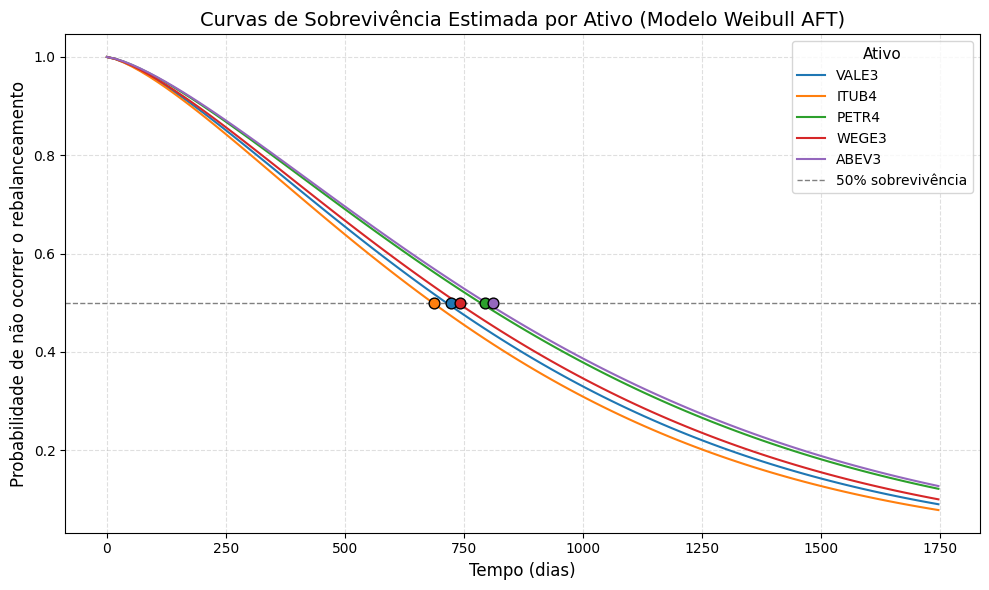

In [37]:
# -----------------------------------
# 3. PLOTAR CURVAS DE SOBREVIVÊNCIA
# ----------------------------------
# Cria figura e eixos
fig, ax = plt.subplots(figsize=(10, 6))

# Paleta de cores para distinguir os ativos
cores = sns.color_palette("tab10", n_colors=len(ativos))

# Plota curvas de sobrevivência por ativo
for i, ativo in enumerate(ativos):
    # Cria amostra com zeros e ativa a dummy correspondente (se existir)
    amostra = pd.DataFrame({col: [0] for col in df_model.columns if col not in ['Tempo', 'Evento']})

    # Ativa a dummy do ativo, se ela existir
    col_dummy = f'Ativo_{ativo}'
    if col_dummy in amostra.columns:
        amostra[col_dummy] = 1
    else:
        print(f"Aviso: Dummy {col_dummy} não encontrada no modelo.")

    # Opcional: incluir frailty médio (se existir)
    if 'Frailty' in amostra.columns:
        amostra['Frailty'] = df_model['Frailty'].mean()

    # Gera curva de sobrevivência
    tempos = np.linspace(0.1, df_eventos['Tempo'].max(), 100)
    surv_func = aft.predict_survival_function(amostra, times=tempos)

    # Plota curva
    ax.plot(surv_func.index, surv_func.values.flatten(),
            label=ativo, color=cores[i])

    # Mediana de sobrevivência (onde sobrevive = 0.5)
    y = surv_func.values.flatten()
    x = surv_func.index
    cruzamento = np.where(y <= 0.5)[0]
    if cruzamento.size > 0:
        tempo_mediano = x[cruzamento[0]]
        ax.scatter(tempo_mediano, 0.5, color=cores[i],
                   s=60, marker='o', edgecolor='black', zorder=5)
    else:
        print(f"A curva de {ativo} não atinge 50% de sobrevivência no período analisado.")

# Linha horizontal em 50%
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='50% sobrevivência')

# Labels
ax.set_title('Curvas de Sobrevivência Estimada por Ativo (Modelo Weibull AFT)', fontsize=14)
ax.set_xlabel('Tempo (dias)', fontsize=12)
ax.set_ylabel('Probabilidade de não ocorrer o rebalanceamento', fontsize=12)

# Legenda
ax.legend(title="Ativo", fontsize=10, title_fontsize=11)

# Grid e estética
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# **Pré-cálculos para a Etapa de Otimização Bayesiana com Optuna**

Antes da execução da etapa de otimização propriamente dita, foram realizados pré-cálculos essenciais para alimentar a função objetivo utilizada na etapa 4, onde se aplica a otimização bayesiana com o pacote Optuna. Essa preparação envolve o cálculo de métricas fundamentais associadas ao desempenho dos ativos financeiros: retorno e risco.

Primeiramente, os retornos diários dos ativos foram obtidos a partir do histórico de preços (precos_historicos), utilizando a função pct_change() do pandas, que calcula a variação percentual entre dias consecutivos. A função dropna() é aplicada em seguida para eliminar a primeira linha resultante com valor nulo, consequência do cálculo de diferença percentual.

In [38]:
# --------------------------------------------------------------------------
# PRÉ-CÁLCULOS PARA A FUNÇÃO NA 4ª ETAPA DE OTIMIZAÇÃO BAYESIANA COM OPTUNA
# --------------------------------------------------------------------------

# Calcula retornos e riscos históricos
retornos_diarios = precos_historicos.pct_change().dropna()
retornos_ativos = retornos_diarios.mean().to_dict()
riscos_ativos = retornos_diarios.std().to_dict()

# Pesos para combinação de riscos
alpha = 0.7  # peso para risco histórico
beta = 0.3   # peso para risco estrutural (frailty)

# Mapear preços atuais dos ativos
precos_ativos = dict(zip(df_api['Ticker'], df_api['Preço Atual']))
ativos = list(precos_ativos.keys())

# Parâmetros padrão para casos com dados faltantes
RISCO_PADRAO = 0.1
FRAILTY_PADRAO = 0.0

# Combinação dos riscos: histórico + estrutural
riscos_ativos_combinados = {
    ativo: alpha * riscos_ativos.get(ativo, RISCO_PADRAO) +
           beta * abs(frailty_ativos.get(ativo, FRAILTY_PADRAO))  # frailty como risco estrutural (magnitude)
    for ativo in ativos
}

Nesse ponto tentamos responder à seguinte pergunta:

***“Qual seria a melhor alocação percentual nos ativos para maximizar retorno, minimizar risco e evitar rebalanceamentos caros?”***

Este trecho de código realiza a otimização dos pesos dos ativos da carteira utilizando a técnica de Otimização Bayesiana com a biblioteca Optuna. O objetivo principal é encontrar a alocação ideal dos ativos — ou seja, os percentuais que cada ativo deve representar na carteira — de forma que o retorno esperado seja maximizado, enquanto o risco total e os custos de rebalanceamento sejam minimizados.

Primeiramente, são calculados os retornos e riscos reais de cada ativo com base nos preços históricos: o retorno é obtido pela média dos retornos diários e o risco pelo desvio padrão desses retornos. Também é utilizado o tempo mediano de permanência de cada ativo na carteira (calculado anteriormente) como uma forma de penalizar ativos que exigem rebalanceamento muito frequente.

A função objetivo da otimização recebe os pesos sugeridos para os ativos, normaliza esses pesos, e então calcula:

* o retorno esperado da carteira (média ponderada dos retornos),

* o risco total da carteira (média ponderada dos desvios padrão),

* e um custo de rebalanceamento proporcional à frequência com que os ativos são comprados ou vendidos.

Esses três fatores são combinados em uma métrica única chamada "score", que é o valor a ser minimizado durante o processo de otimização. Ao final, o Optuna retorna a melhor combinação de pesos encontrada, representando a composição ótima da carteira segundo os critérios definidos.

In [39]:
# -----------------------------------
# 4. OTIMIZAÇÃO BAYESIANA COM OPTUNA COM RESTRIÇÃO DE APORTES
# -----------------------------------

def funcao_objetivo(trial):
    peso_ativos = np.array([trial.suggest_float(f"peso_{i}", 0.0, 1.0) for i in range(len(ativos))])
    peso_soma = peso_ativos.sum()
    if peso_soma == 0:
        return float('inf')
    peso_ativos /= peso_soma  # Normaliza os pesos

    valor_alocado = peso_ativos * VALOR_APORTE

    quantidades = []
    for i, ativo in enumerate(ativos):
        preco = precos_ativos.get(ativo)
        if preco is None:
            raise ValueError(f"Preço não encontrado para o ativo {ativo}")
        qtd = np.floor(valor_alocado[i] / preco)
        quantidades.append(qtd)

    quantidades = np.array(quantidades)

    if quantidades.sum() == 0:
        return float('inf')

    valor_utilizado = np.sum(quantidades * np.array([precos_ativos[ativo] for ativo in ativos]))
    if valor_utilizado > VALOR_APORTE:
        return float('inf')

    pesos_efetivos = (quantidades * np.array([precos_ativos[ativo] for ativo in ativos])) / valor_utilizado

    retornos = np.array([retornos_ativos.get(ativo, 0.0) for ativo in ativos])
    riscos = np.array([riscos_ativos_combinados.get(ativo, 0.1) for ativo in ativos])

    retorno_esperado = np.dot(pesos_efetivos, retornos)
    risco_total = np.dot(pesos_efetivos, riscos)

    # Objetivo: maximizar retorno e minimizar risco (via score = retorno - risco)
    return -(retorno_esperado - risco_total)


# Execução do estudo com Optuna

study = optuna.create_study(direction="minimize")
study.optimize(funcao_objetivo, n_trials=300)

# Impressão dos melhores resultados

print("\nMelhores alocações considerando o aporte:")

peso_ativos = np.array([study.best_params.get(f"peso_{i}", 0.0) for i in range(len(ativos))])
peso_ativos /= peso_ativos.sum()
valor_alocado = peso_ativos * VALOR_APORTE

quantidades = np.floor(valor_alocado / np.array([precos_ativos[ativo] for ativo in ativos]))
valor_total_utilizado = 0

pesos_efetivos = []

for i, ativo in enumerate(ativos):
    preco = precos_ativos.get(ativo)
    quantidade = quantidades[i]
    if quantidade > 0:
        valor_ativo = quantidade * preco
        valor_total_utilizado += valor_ativo
        pesos_efetivos.append(valor_ativo)
        print(f"{ativo}: {int(quantidade)} ações (Preço: {preco:.2f}, Valor: {valor_ativo:.2f})")
    else:
        pesos_efetivos.append(0)

pesos_efetivos = np.array(pesos_efetivos) / valor_total_utilizado

print(f"\nValor total utilizado do aporte: R$ {valor_total_utilizado:.2f} de R$ {VALOR_APORTE:.2f}")

retorno_final = np.dot(pesos_efetivos, np.array([retornos_ativos[ativo] for ativo in ativos]))
risco_final = np.dot(pesos_efetivos, np.array([riscos_ativos_combinados[ativo] for ativo in ativos]))

print(f"\nRetorno esperado: {retorno_final:.4f}")
print(f"Risco total: {risco_final:.4f}")

if valor_total_utilizado > VALOR_APORTE:
    print("\n⚠️ Atenção: O valor total utilizado ultrapassa o aporte! Corrija a função de alocação.")
else:
    print("\n✅ A alocação está dentro do valor do aporte.")

[I 2025-06-28 16:30:17,730] A new study created in memory with name: no-name-b76fd26e-7b29-431a-8ac8-a41a59589643
[I 2025-06-28 16:30:17,735] Trial 0 finished with value: 0.19234054898099084 and parameters: {'peso_0': 0.4968536470418342, 'peso_1': 0.26729452960658184, 'peso_2': 0.9473512837903718, 'peso_3': 0.0359663326325258, 'peso_4': 0.5930242318282338}. Best is trial 0 with value: 0.19234054898099084.
[I 2025-06-28 16:30:17,737] Trial 1 finished with value: 0.18657890012778042 and parameters: {'peso_0': 0.23989500988269075, 'peso_1': 0.01932142299660955, 'peso_2': 0.3175712456128156, 'peso_3': 0.3641514874627707, 'peso_4': 0.9987157263532088}. Best is trial 1 with value: 0.18657890012778042.
[I 2025-06-28 16:30:17,739] Trial 2 finished with value: 0.20438222288645458 and parameters: {'peso_0': 0.5644918718522619, 'peso_1': 0.3527150429283086, 'peso_2': 0.4822775933858038, 'peso_3': 0.6450491933321515, 'peso_4': 0.6845911104364237}. Best is trial 1 with value: 0.18657890012778042.
[


Melhores alocações considerando o aporte:
VALE3: 1 ações (Preço: 53.00, Valor: 53.00)
PETR4: 16 ações (Preço: 31.21, Valor: 499.36)
ABEV3: 332 ações (Preço: 13.15, Valor: 4365.80)

Valor total utilizado do aporte: R$ 4918.16 de R$ 5000.00

Retorno esperado: 0.0243
Risco total: 0.1790

✅ A alocação está dentro do valor do aporte.


In [40]:
# Converte os dicionários para arrays na mesma ordem de 'ativos'
retorno_ativos_array = np.array([retornos_ativos[ativo] for ativo in ativos])

risco_ativos_array = np.array([riscos_ativos.get(ativo, 0.1) for ativo in ativos])

rebal_freq_array = np.array([
    1 / tempo if tempo != 0 else 0
    for tempo in [tempos_por_ticker.get(ativo, 1) for ativo in ativos]
])# frequência ≈ 1 / tempo mediano

# **Otimização Multiobjetivo com NSGA-II e MOPSO (via PyMoo)**

Nesta etapa do trabalho, foi implementado um modelo de otimização multiobjetivo com o uso do pacote pymoo, visando a construção de carteiras de investimento eficientes sob múltiplos critérios simultâneos. O modelo considera três objetivos principais: maximizar o retorno esperado, minimizar o risco (medido pelo desvio padrão dos retornos) e minimizar o custo de rebalanceamento da carteira. Para isso, foi definida uma classe personalizada (CarteiraMultiObjetivo) que representa formalmente o problema de otimização a ser resolvido por algoritmos evolutivos como NSGA-II e MOPSO.

Cada carteira é representada por um vetor de pesos, em que cada valor corresponde à proporção de capital alocada em um ativo. A função de avaliação calcula o retorno como o somatório ponderado dos retornos médios dos ativos, o risco como a soma ponderada das volatilidades individuais e o custo de rebalanceamento como uma penalidade proporcional à frequência com que os ativos são ajustados na carteira. Como o pymoo realiza minimizações por padrão, o retorno é invertido (multiplicado por -1) para que seu valor máximo represente a melhor solução. Além disso, é imposta uma restrição que obriga a soma dos pesos a ser igual a 1, garantindo que 100% do capital esteja alocado.

Essa modelagem permite explorar a fronteira de Pareto, onde nenhuma solução é superior a outra em todos os critérios ao mesmo tempo. Assim, o investidor pode tomar decisões mais informadas com base em seu perfil de risco e preferências em relação a custo e retorno.





In [41]:
# -----------------------------
# 5. OTIMIZAÇÃO MULTIOBJETIVO COM NSGA-II
# -----------------------------

# Define o problema de otimização multiobjetivo
class CarteiraMultiObjetivo(Problem):
    def __init__(self):
        super().__init__(
            n_var=len(ativos),   # número de ativos
            n_obj=3,             # retorno, risco e custo
            n_constr=1,          # soma dos pesos = 1
            xl=0.0,              # limite inferior dos pesos
            xu=1.0               # limite superior dos pesos
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x)

        # Calcula os 3 objetivos
        retorno = np.dot(x, retorno_ativos_array)
        risco = np.dot(x, risco_ativos_array)
        custo = np.dot(x, rebal_freq_array) * 0.01  # penalidade por frequência de rebalanceamento

        # Define objetivos (lembrando: pymoo minimiza → -retorno para maximizar)
        out["F"] = np.column_stack([-retorno, risco, custo])

        # Restrição: soma dos pesos deve ser 1
        out["G"] = np.sum(x, axis=1) - 1

# Instancia o problema
problem = CarteiraMultiObjetivo()

In [42]:
# Parametros de numero de gerações comuns a todos os algoritmos
n_geracoes = 100
termination = get_termination("n_gen", n_geracoes)

Nesta etapa, foi configurado e executado o algoritmo evolutivo NSGA-II (Non-dominated Sorting Genetic Algorithm II), amplamente utilizado em problemas de otimização multiobjetivo. A configuração do algoritmo foi feita utilizando os componentes disponíveis na biblioteca pymoo, com parâmetros ajustados para balancear diversidade e convergência na busca por soluções eficientes.

A população inicial foi definida com 100 indivíduos (pop_size=100), e a amostragem inicial dos pesos das carteiras foi feita de forma aleatória contínua com FloatRandomSampling. Para promover a recombinação entre indivíduos, foi utilizado o operador de crossover SBX (Simulated Binary Crossover) com probabilidade de 90% e parâmetro de distribuição η = 15. Além disso, foi aplicado o operador de mutação polinomial (Polynomial Mutation - PM) com η = 20, promovendo variações nos indivíduos para evitar estagnação prematura. A opção eliminate_duplicates=True garante diversidade populacional ao eliminar soluções repetidas.

Com o algoritmo configurado, a otimização foi executada por meio da função minimize, que recebe como parâmetros o problema previamente definido (classe CarteiraMultiObjetivo), o algoritmo NSGA-II, os critérios de terminação (termination), uma semente aleatória fixa (seed=1) para garantir reprodutibilidade dos resultados, e a opção save_history=True para armazenar a evolução das soluções ao longo das gerações. A flag verbose=False foi definida para evitar a exibição contínua de logs durante a execução.

Essa configuração permitiu a exploração eficiente do espaço de soluções, resultando em um conjunto de carteiras não-dominadas que compõem a fronteira de Pareto, possibilitando ao investidor escolher entre diferentes trade-offs entre retorno, risco e custo.

In [43]:
# -----------------------------
# Configurar algoritmo NSGA-II
# -----------------------------
algorithm_nsga2 = NSGA2(
    pop_size=100,                               # tamanho da população
    sampling=FloatRandomSampling(),             # amostragem inicial aleatória contínua
    crossover=SBX(prob=0.9, eta=15),            # operador de crossover Simulated Binary
    mutation=PM(eta=20),                        # operador de mutação polinomial
    eliminate_duplicates=True                   # evita duplicatas na população
)

# -----------------------------
# Executar otimização
# -----------------------------
res_nsga2 = minimize(
    problem,                                    # problema de otimização definido
    algorithm_nsga2,                            # algoritmo NSGA-II
    termination,                                # critério de parada
    seed=1,                                     # para reprodutibilidade
    save_history=True,                          # salva histórico de gerações
    verbose=False                               # suprime saída detalhada
)

**📊 Resumo do gráfico de convergência (Hypervolume)**

Nesta etapa final, foi realizada a avaliação da qualidade das soluções obtidas ao longo da execução do algoritmo NSGA-II por meio do cálculo do Indicador de Hipervolume (HV – Hypervolume Indicator), além da identificação da solução mais balanceada entre os objetivos considerados (retorno, risco e custo). Por fim, um gráfico foi gerado para ilustrar a evolução da qualidade da fronteira ao longo das gerações.

Primeiramente, todas as frentes de Pareto geradas a cada geração foram empilhadas (all_F) para determinar um ponto de referência 10% acima dos piores valores encontrados em cada objetivo. Esse ponto de referência é necessário para o cálculo do hipervolume, que mede o volume do espaço dominado pelas soluções não dominadas em relação a esse ponto.

Em seguida, para cada geração armazenada no histórico do algoritmo (res_nsga2.history), foi computado o hipervolume da população daquela geração utilizando a função HV da biblioteca pymoo. Isso resultou em uma lista de valores de HV (hv_values), que permite visualizar se houve convergência e melhora na qualidade das soluções ao longo do tempo.

Além disso, foi implementado um procedimento para encontrar a solução mais balanceada, isto é, aquela que apresenta o menor somatório de rankings normalizados entre os três objetivos. Isso foi feito ordenando os valores de retorno, risco e custo separadamente, atribuindo ranks a cada solução e, posteriormente, somando esses ranks. A solução com a menor soma de ranks foi identificada como a mais equilibrada e seu índice dentro da fronteira final foi armazenado.

Para fins de interpretação visual, foi criado um gráfico com a curva de evolução do HV ao longo das gerações. A geração em que surgiu a solução mais balanceada foi destacada com uma linha vertical vermelha e anotada com suas métricas de desempenho (valores de retorno, risco e custo convertidos para porcentagens), facilitando a identificação de trade-offs entre os objetivos. Essa visualização fornece uma ferramenta prática para analisar a eficiência da otimização e selecionar carteiras de investimento com base em múltiplos critérios simultâneos.

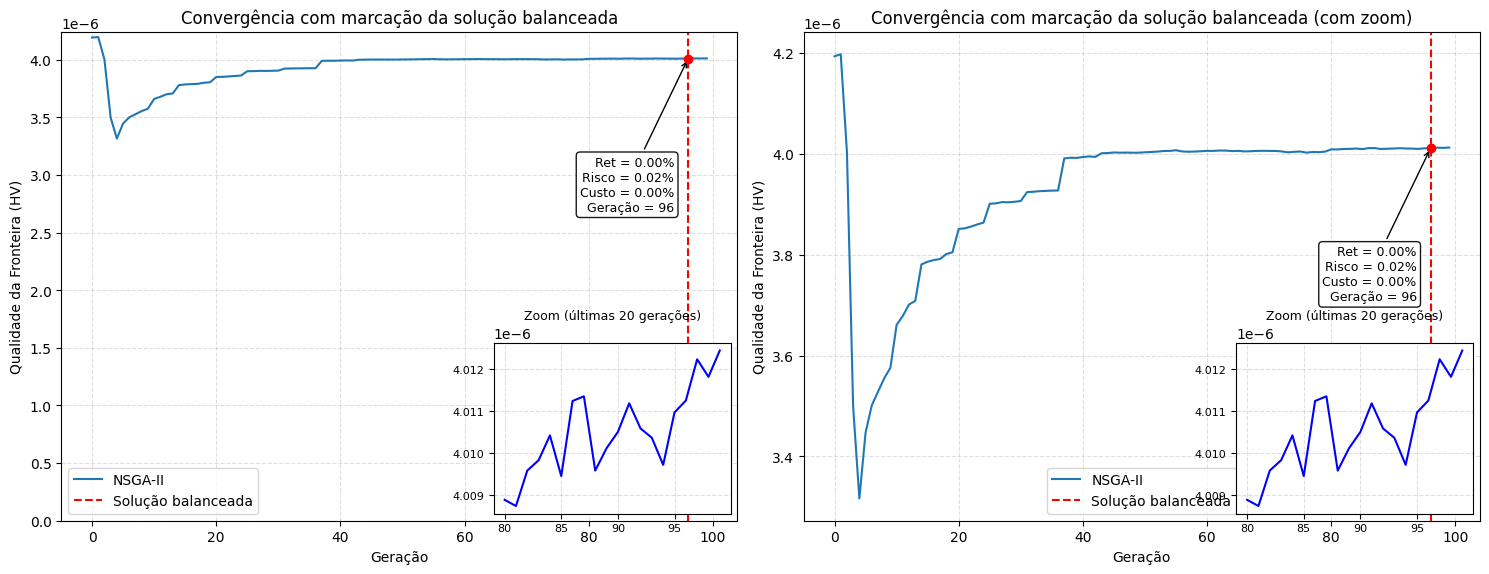

In [88]:
# -----------------------------
# Calcular HV por geração
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_nsga2.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de referência 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = [hv.do(gen.pop.get("F")) for gen in res_nsga2.history]

# -----------------------------
# Encontrar solução mais balanceada (mínima soma de ranks)
# -----------------------------

pareto_objectives = res_nsga2.F  # [ -retorno, risco, custo ]

rankings = np.zeros_like(pareto_objectives)
for i in range(pareto_objectives.shape[1]):
    rankings[:, i] = np.argsort(np.argsort(pareto_objectives[:, i]))

rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)
melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual geração essa solução apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_nsga2.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj, rtol=1e-5, atol=1e-8):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Função reutilizável para plotar
# -----------------------------

def plot_hv(ax, hv_values, title, show_annotation=False, ylim_zero=False):
    ax.plot(np.arange(len(hv_values)), hv_values, label='NSGA-II')

    if ylim_zero:
        ax.set_ylim(bottom=0)

    if show_annotation and geracao_melhor_balanceada is not None:
        # Linha vertical da solução balanceada
        ax.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solução balanceada')
        ax.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

        # Texto de anotação
        x_text = ax.get_xlim()[1] - 10
        y_text = ax.get_ylim()[1] * 0.95

        ax.annotate(
            f'Ret = {-melhor_obj[0]*100:.2f}%\nRisco = {melhor_obj[1]*100:.2f}%\nCusto = {melhor_obj[2]*100:.2f}%\nGeração = {geracao_melhor_balanceada}',
            xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),
            xytext=(-10, -70),  # mais à direita (x) e mais abaixo (y)
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'),
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9),
            ha='right',  # alinha à direita da caixa de texto
            va='top'     # alinha o topo da caixa com o ponto de origem
        )

        # Inserir gráfico de zoom no canto inferior direito
        ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")
        zoom_start = max(0, len(hv_values) - 20)
        zoom_end = len(hv_values)
        ax_inset.plot(np.arange(zoom_start, zoom_end), hv_values[zoom_start:zoom_end], color='blue')
        ax_inset.set_title("Zoom (últimas 20 gerações)", fontsize=9)
        ax_inset.grid(True, linestyle='--', alpha=0.4)
        ax_inset.tick_params(labelsize=8)

    ax.set_title(title)
    ax.set_xlabel("Geração")
    ax.set_ylabel("Qualidade da Fronteira (HV)")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend()

# -----------------------------
# Criar gráfico com subplots lado a lado
# -----------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico com anotação e zoom
plot_hv(ax1, hv_values, "Convergência com marcação da solução balanceada", show_annotation=True, ylim_zero=True)

# Gráfico com y iniciando em zero
plot_hv(ax2, hv_values, "Convergência com marcação da solução balanceada (com zoom)", show_annotation=True, ylim_zero=False)

plt.tight_layout()
plt.show()

Nesta etapa final do processo, foi realizado o plot da fronteira de Pareto em três dimensões para comparar visualmente os resultados obtidos pelos três algoritmos utilizados: NSGA-II, NSGA-III e R-NSGA-II. Cada subgráfico apresenta uma nuvem de pontos representando as soluções não-dominadas encontradas por cada algoritmo no espaço dos três objetivos: retorno, risco e custo.

Como o retorno foi modelado para ser minimizado durante o processo de otimização (ou seja, convertido em negativo), ele foi invertido no momento da visualização (-res.F[:, 0]) para que os gráficos reflitam corretamente a lógica intuitiva de que maior retorno é melhor.

Esse tipo de visualização é essencial para comparar a distribuição e a qualidade das soluções encontradas, identificando por exemplo quais algoritmos tendem a explorar melhor certas regiões da fronteira de Pareto, ou quais apresentam maior diversidade e cobertura em relação aos objetivos.

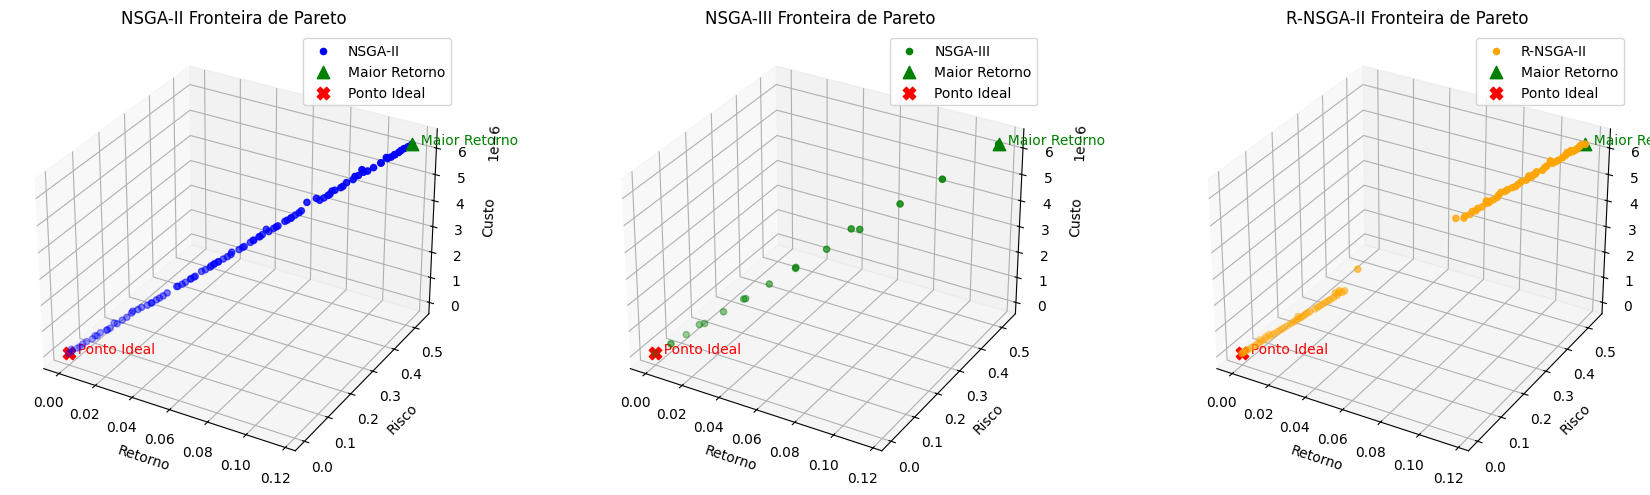

In [28]:
# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------

def marcar_pontos(ax, F):
    retorno = -F[:, 0]  # Inverte para maximizar
    risco = F[:, 1]
    custo = F[:, 2]

    # Ponto com maior retorno
    idx_max_ret = np.argmax(retorno)
    ponto_max_ret = (retorno[idx_max_ret], risco[idx_max_ret], custo[idx_max_ret])
    ax.scatter(*ponto_max_ret, c='green', s=80, marker='^', label='Maior Retorno')
    ax.text(*ponto_max_ret, '  Maior Retorno', color='green')

    # Ponto ideal: maior retorno, menor risco e menor custo
    idx_ideal = np.argmax(retorno - risco - custo)
    ponto_ideal = (retorno[idx_ideal], risco[idx_ideal], custo[idx_ideal])
    ax.scatter(*ponto_ideal, c='red', s=80, marker='X', label='Ponto Ideal')
    ax.text(*ponto_ideal, '  Ponto Ideal', color='red')

# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------
fig = plt.figure(figsize=(18, 5))

# NSGA-II
ax1 = fig.add_subplot(131, projection='3d')
retorno_nsga2 = -res_nsga2.F[:, 0]
ax1.scatter(retorno_nsga2, res_nsga2.F[:, 1], res_nsga2.F[:, 2], c='blue', label='NSGA-II')
ax1.set_title('NSGA-II Fronteira de Pareto')
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Risco')
ax1.set_zlabel('Custo')
marcar_pontos(ax1, res_nsga2.F)
ax1.legend()

# NSGA-III
ax2 = fig.add_subplot(132, projection='3d')
retorno_nsga3 = -res_nsga3.F[:, 0]
ax2.scatter(retorno_nsga3, res_nsga3.F[:, 1], res_nsga3.F[:, 2], c='green', label='NSGA-III')
ax2.set_title('NSGA-III Fronteira de Pareto')
ax2.set_xlabel('Retorno')
ax2.set_ylabel('Risco')
ax2.set_zlabel('Custo')
marcar_pontos(ax2, res_nsga3.F)
ax2.legend()

# R-NSGA-II
ax3 = fig.add_subplot(133, projection='3d')
retorno_rnsga2 = -res_rnsga2.F[:, 0]
ax3.scatter(retorno_rnsga2, res_rnsga2.F[:, 1], res_rnsga2.F[:, 2], c='orange', label='R-NSGA-II')
ax3.set_title('R-NSGA-II Fronteira de Pareto')
ax3.set_xlabel('Retorno')
ax3.set_ylabel('Risco')
ax3.set_zlabel('Custo')
marcar_pontos(ax3, res_rnsga2.F)
ax3.legend()

plt.tight_layout()
plt.show()